# 제 1유형

> 데이터셋: airquality.csv
* 주어지는 데이터는 153일 동안 공기의 질을 측정한 데이터셋이다.
    * Ozone: 오존 농도
    * Solar.R: 태양 복사 강도
    * Wind: 평균 풍속
    * Temp: 최대 온도
    * Month: 월
    * Day: 일

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv("airquality.csv")

>(1) airquality 데이터에 대해서 결측치가 가장 많은 변수를 찾아서 해당 결측치를 0으로 대치하고, 결측치를 제외한 평균과 0으로 대치한 후의 평균과의 차이를 구하시오.

In [ ]:
print(df.shape)
df.isna().sum()

(153, 6)


Ozone      37
Solar.R     7
Wind        0
Temp        0
Month       0
Day         0
dtype: int64

In [ ]:
most_na_col = df["Ozone"]
most_na_col_clean = most_na_col.fillna(0)

print(most_na_col.mean() - most_na_col_clean.mean())

10.188133874239352


> (2) Wind 변수에 대해서 Min-Max 정규화를 수행한 후 평균값과 Z 정규화를 수행한 후 평균값의 차이를 구하시오.

In [ ]:
min_max_wind = (df["Wind"] - df["Wind"].min()) / (df["Wind"].max() - df["Wind"].min())
z_wind = (df["Wind"] - df["Wind"].mean()) / df["Wind"].std()

print(min_max_wind.mean(), z_wind.mean())
print(min_max_wind.mean() - z_wind.mean())

0.4346061231510147 -3.483052626275001e-17
0.43460612315101477


In [ ]:
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mm_scaler = MinMaxScaler()
z_scaler = StandardScaler()

min_max_wind = mm_scaler.fit_transform(df[["Wind"]])
z_wind = z_scaler.fit_transform(df[["Wind"]])

print(min_max_wind.mean(), z_wind.mean())
print(min_max_wind.mean() - z_wind.mean())

0.4346061231510147 -2.322035084183334e-17
0.4346061231510147


> (3) 월별(5월~9월) 평균 기온을 구하시오.

In [ ]:
print(df.groupby("Month").agg({"Temp": pd.Series.mean}))

            Temp
Month           
5      65.548387
6      79.100000
7      83.903226
8      83.967742
9      76.900000


# 제 2유형
> 데이터셋: Bank_Personal_Loan_Modeling.csv
* https://www.kaggle.com/teertha/personal-loan-modeling
* 은행 고객 5,000명에 대한 데이터로 인구통계정보(연령, 소득 등), 고객과의 관계(담보, 증권계좌 등), 개인대출 등의 금융정보를 포함한다.

> 은행에서 수집한 고객 5,000명의 금융정보에 따른 대출여부가 들어있는 참조데이터를 이용하여 대출 여부를 분류하는 가장 최적의 이웃의 크기값(k)을 구하고, 이때 분류정확도를 산출하시오.<br>
(단, 참조데이터는 7:3의 비율로 트레이닝 데이터와 테스트 데이터로 구분하고, 트레이닝 데이터와 테스트 데이터의 대출여부(y)의 비율도 유지한다. 또한 normalizer를 사용하여 스케일링을 진행한다.)

## KNN 수행 

### 1) 필요 패키지 임포트 

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

### 2) 데이터 불러오기 

In [ ]:
df = pd.read_csv("Bank_Personal_Loan_Modelling.csv")

### 3) 데이터 살펴보기 

In [ ]:
df

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0


* Age: 고객의 나이
* Experience: 고객의 직업 경험 기간
* Income: 고객의 연간 수입
* CCAvg: 고객의 월평균 신용카드 사용금액
* Education: 고객의 교육수준(1: undergrade, 2: graduate, 3: advanced/professional)
* Mortgage: 고객의 주택 담보 가치
* Personal Loan: 대출여부(1: 대출, 0:미대출), 종속변수
* Securities Account: 고객의 증권계좌 보유 여부
* CD Account: 고객의 예금증서 보유여부
* Online: 고객의 온라인 뱅킹 여부
* CreditCard: 고객의 신용카드 발급 여부 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


결측값 없음.

In [ ]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


### 4) 데이터 전처리 
* 분석에 불필요한 열인 ID와 ZIP code 삭제 

In [ ]:
df = df.drop(["ID", "ZIP Code"], axis=1)

* 독립변수와 종속변수 나눔 

In [ ]:
X = df.drop("Personal Loan", axis=1)
y = df["Personal Loan"]

* 종속변수의 비율을 유지하기 위해서 train_test_split() 함수에 stratify 옵션을 y로 둠 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3500, 11)
(1500, 11)
(3500,)
(1500,)


* Normalizer 를 이용해 정규화 수행 

In [ ]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer()

* 훈련 데이터로 학습된 mean과 variance 값을 테스트 데이터에 적용하기 위해서 훈련 데이터에는 fit_transform(), 테스트 데이터에는 transform() 함수를 사용 

In [ ]:
X_train = scaler.fit_transform(X_train)
# 혹은 
# X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.transform(X_test)

### 5) 데이터 분석 수행 

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

train_acc = []
test_acc = []

for k in range(1,26):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, knn.predict(X_train))
    test_accuracy = accuracy_score(y_test, knn.predict(X_test))
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

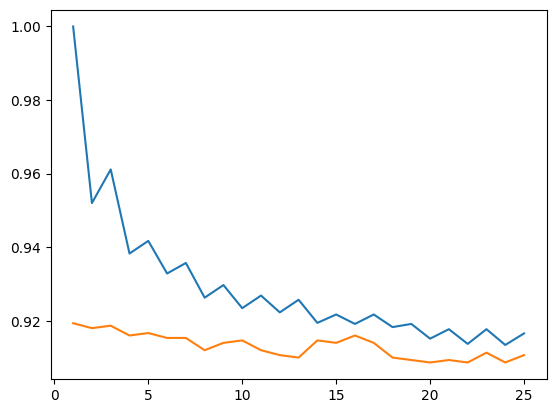

In [ ]:
plt.plot(list(range(1,26)), train_acc, label="Train Accuracy")
plt.plot(list(range(1,26)), test_acc, label="Test Accuracy")
plt.show()

In [ ]:
test_acc.index(max(test_acc))

0

In [ ]:
test_acc

[0.9193333333333333,
 0.918,
 0.9186666666666666,
 0.916,
 0.9166666666666666,
 0.9153333333333333,
 0.9153333333333333,
 0.912,
 0.914,
 0.9146666666666666,
 0.912,
 0.9106666666666666,
 0.91,
 0.9146666666666666,
 0.914,
 0.916,
 0.914,
 0.91,
 0.9093333333333333,
 0.9086666666666666,
 0.9093333333333333,
 0.9086666666666666,
 0.9113333333333333,
 0.9086666666666666,
 0.9106666666666666]

**k=1 일때 분류 정확도가 가장 높고 그때의 정확도는 91.93% 이다.**



---



---



## 불균형 데이터의 문제 

In [ ]:
all_zeros = [0 for i in range(len(y_test))]

* 높은 비율의 클래스로 모두 분류를 하더라도 정확도가 90% 가 넘는다.

In [ ]:
accuracy_score(y_test, all_zeros)

0.904

In [ ]:
confusion_matrix(y_test, all_zeros)

array([[1356,    0],
       [ 144,    0]])

### 오버샘플링 시행 

In [ ]:
from imblearn.over_sampling import SMOTE

smote_sample = SMOTE(random_state=123)

X_smote_train, y_smote_train = smote_sample.fit_resample(X_train, y_train)

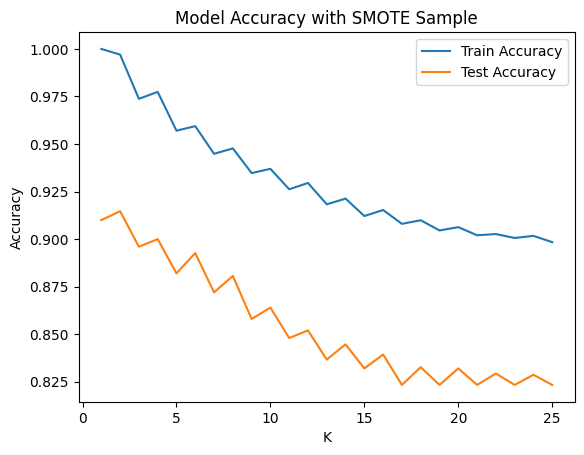

In [ ]:
train_acc = []
test_acc = []

for k in range(1,26):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_smote_train, y_smote_train)
    train_accuracy = accuracy_score(y_smote_train, knn.predict(X_smote_train))
    train_acc.append(train_accuracy)

    test_accuracy = accuracy_score(y_test, knn.predict(X_test))
    test_acc.append(test_accuracy)

plt.plot(range(1,26), train_acc, label="Train Accuracy")
plt.plot(range(1,26), test_acc, label="Test Accuracy")
plt.title("Model Accuracy with SMOTE Sample")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
test_acc

[0.91,
 0.9146666666666666,
 0.896,
 0.9,
 0.882,
 0.8926666666666667,
 0.872,
 0.8806666666666667,
 0.858,
 0.864,
 0.848,
 0.852,
 0.8366666666666667,
 0.8446666666666667,
 0.832,
 0.8393333333333334,
 0.8233333333333334,
 0.8326666666666667,
 0.8233333333333334,
 0.832,
 0.8233333333333334,
 0.8293333333333334,
 0.8233333333333334,
 0.8286666666666667,
 0.8233333333333334]

k=2 일때 정확도가 가장 좋음 91.47% 

* SMOTE로 오버샘플링한 훈련 데이터를 이용한 knn

In [ ]:
from sklearn.metrics import classification_report

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_smote_train, y_smote_train)
pred = knn.predict(X_test)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[1283   73]
 [  55   89]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1356
           1       0.55      0.62      0.58       144

    accuracy                           0.91      1500
   macro avg       0.75      0.78      0.77      1500
weighted avg       0.92      0.91      0.92      1500



* 오버샘플링 하지 않은 데이터를 이용한 knn 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[1301   55]
 [  66   78]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1356
           1       0.59      0.54      0.56       144

    accuracy                           0.92      1500
   macro avg       0.77      0.75      0.76      1500
weighted avg       0.92      0.92      0.92      1500



비슷한 결과가 나왔다.


---



---



## 랜덤 포레스트 이용 

### 1) 원래의 데이터 

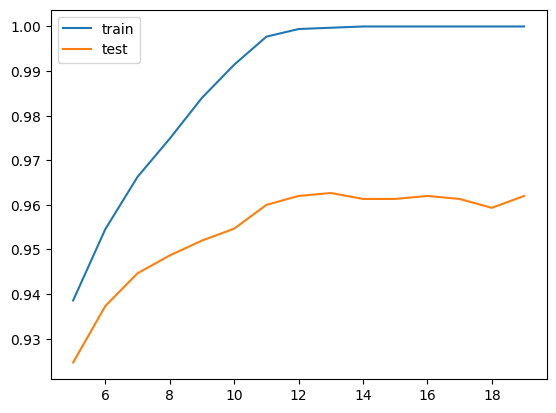

In [ ]:
from sklearn.ensemble import RandomForestClassifier

train_acc = []
test_acc = []

for depth in range(5, 20):
    rf = RandomForestClassifier(max_depth=depth, random_state=123)
    rf.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, rf.predict(X_train)))
    test_acc.append(accuracy_score(y_test, rf.predict(X_test)))

plt.plot(range(5,20), train_acc, label="train")
plt.plot(range(5,20), test_acc, label="test")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame(test_acc, index=range(5,20), columns=["acc"]).sort_values("acc", ascending=False)

,acc
13,0.962667
12,0.962000
16,0.962000
19,0.962000
14,0.961333
15,0.961333
17,0.961333
11,0.960000
18,0.959333
10,0.954667


max_depth가 13 일때 가장 정확도가 높음 

In [ ]:
rf = RandomForestClassifier(max_depth=13, random_state=123)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

imb_mat = confusion_matrix(y_test, pred)
imb_rpt = classification_report(y_test, pred)

### 2) SMOTE 데이터 이용 

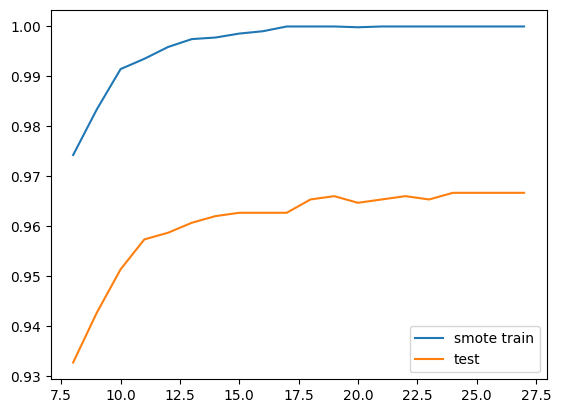

In [ ]:
train_acc = []
test_acc = []

for depth in range(8, 28):
    rf = RandomForestClassifier(max_depth=depth, random_state=123)
    rf.fit(X_smote_train, y_smote_train)
    train_acc.append(accuracy_score(y_smote_train, rf.predict(X_smote_train)))
    test_acc.append(accuracy_score(y_test, rf.predict(X_test)))

plt.plot(range(8,28), train_acc, label="smote train")
plt.plot(range(8,28), test_acc, label="test")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame(test_acc, index=range(8,28), columns=["acc"]).sort_values("acc", ascending=False)

,acc
27,0.966667
26,0.966667
25,0.966667
24,0.966667
19,0.966000
22,0.966000
23,0.965333
21,0.965333
18,0.965333
20,0.964667


max_depth 가 24 일때 96.67% 정확도 

In [ ]:
rf = RandomForestClassifier(max_depth=24, random_state=123)
rf.fit(X_smote_train, y_smote_train)
pred = rf.predict(X_test)

b_mat = confusion_matrix(y_test, pred)
b_rpt = classification_report(y_test, pred)

### 3) 비교 

In [ ]:
print("불균형 처리를 하지 않은 데이터 이용")
print(imb_mat)
print(imb_rpt, "\n")
print("SMOTE 방법으로 불균형 처리를 한 데이터 이용")
print(b_mat)
print(b_rpt)

불균형 처리를 하지 않은 데이터 이용
[[1348    8]
 [  48   96]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1356
           1       0.92      0.67      0.77       144

    accuracy                           0.96      1500
   macro avg       0.94      0.83      0.88      1500
weighted avg       0.96      0.96      0.96      1500
 

SMOTE 방법으로 불균형 처리를 한 데이터 이용
[[1333   23]
 [  27  117]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1356
           1       0.84      0.81      0.82       144

    accuracy                           0.97      1500
   macro avg       0.91      0.90      0.90      1500
weighted avg       0.97      0.97      0.97      1500



* 불균형 처리를 한 데이터를 이용하는 것이 f1스코어가 더 높게 나타났다. 
* 실제 대출을 받은 사람을 더 많이 옳게 예측 함 